## **Fashion-MNIST 분류 및 전이학습 가이드**

### **1. 목표**

- Fashion-MNIST 데이터셋을 분류하는 신경망 모델을 작성합니다.
- 사전학습된 모델(MobileNetV2)을 사용하여 전이학습과 파인튜닝을 진행합니다.
- 데이터 증강(Data Augmentation)을 적용하여 학습 데이터를 늘립니다.
- 모델 성능을 높이기 위한 기법 5가지를 실습에 포함합니다.
- K-Fold Cross Validation과 앙상블 기법을 활용하여 성능을 더욱 향상시킵니다.

---

### **2. 실습 단계**

### **Step 1: 데이터 로드 및 전처리**

1. `tensorflow.keras.datasets`에서 `fashion_mnist` 데이터를 로드합니다.
2. 데이터를 0~1 범위로 정규화하고, 채널 차원을 추가합니다.
3. 입력 이미지를 MobileNetV2 모델과 호환되도록 96x96 크기로 업샘플링합니다.

### **Step 2: 데이터 증강(Data Augmentation)**

1. `ImageDataGenerator`를 사용하여 데이터 증강을 설정합니다.
    - 회전: `rotation_range=20`
    - 이동: `width_shift_range=0.2`, `height_shift_range=0.2`
    - 플립: `horizontal_flip=True`
2. 증강된 데이터를 학습에 활용하도록 준비합니다.

### **Step 3: 사전학습 모델 준비 (Transfer Learning)**

1. MobileNetV2 모델을 `tensorflow.keras.applications`에서 로드합니다.
    - `weights='imagenet'`, `include_top=False`, `input_shape=(96, 96, 3)`
2. `base_model.trainable=False`로 설정하여 초기에는 사전학습된 가중치를 고정합니다.

### **Step 4: 모델 구성**

1. 사전학습 모델 위에 새로운 층을 추가합니다:
    - Global Average Pooling 층.
    - Fully Connected Dense 층 (128 units, ReLU 활성화, L2 정규화 적용).
    - Dropout 층 (20%).
    - Batch Normalization 층.
    - 출력 층 (10개의 클래스, Softmax 활성화).

### **Step 5: 모델 컴파일 및 학습**

1. Adam 옵티마이저를 사용하여 모델을 컴파일합니다.
2. Early Stopping을 설정하여 검증 성능이 더 이상 개선되지 않을 때 학습을 중단합니다.
3. 증강된 데이터를 사용해 모델을 학습시킵니다.

### **Step 6: 파인튜닝 (Fine-Tuning)**

1. `base_model.trainable=True`로 변경하여 사전학습된 모델의 일부 층을 학습 가능하도록 설정합니다.
2. 낮은 학습률(예: 0.0001)로 모델을 다시 컴파일하고 추가 학습을 진행합니다.

### **Step 7: K-Fold Cross Validation**

1. 데이터를 K개의 폴드로 나누어 교차 검증을 수행합니다.
2. 각 폴드에서 모델을 학습시키고 성능을 평가한 뒤 평균 성능을 계산합니다.
3. K-Fold를 적용해 학습 데이터의 활용도를 극대화합니다.
    

### **Step 8: 앙상블 기법 적용**

1. 서로 다른 구조의 모델을 학습시킨 후 결과를 결합하여 최종 성능을 향상시킵니다.

### **앙상블 방법**

- **소프트보팅(Soft Voting)**: 각 모델의 확률 출력 값을 평균하여 최종 결과 결정.
- **하드보팅(Hard Voting)**: 각 모델의 예측 클래스 중 다수결로 최종 결과 결정.
- **가중치 앙상블(Weighted Ensemble)**: 성능 비율에 따라 각 모델의 기여도를 조정.
- **스태킹(Stacking)**: 각 모델의 출력을 메타 모델(Random Forest, XGBoost 등)에 입력으로 사용하여 최종 결과 예측.


### **Step 9: 모델 평가**

1. 테스트 데이터를 사용하여 앙상블된 모델 성능을 평가합니다.
2. 최종 정확도(Accuracy)를 확인합니다.

---

### **3. 성능을 높이기 위한 기법 적용**

1. **Dropout**: 과적합 방지를 위해 뉴런 일부를 비활성화.
2. **L2 정규화**: 손실 함수에 가중치 패널티를 추가해 안정화.
3. **Batch Normalization**: 각 층의 입력을 정규화하여 학습 안정화 및 속도 향상.
4. **Early Stopping**: 검증 성능이 개선되지 않으면 학습 조기 종료.
5. **데이터 증강**: 회전, 이동, 플립 등으로 데이터를 다양화.
6. **K-Fold Cross Validation**: 데이터를 효율적으로 활용하여 성능 평가 안정화.
7. **앙상블 기법**: 여러 모델의 결과를 결합하여 성능 향상.

# Step 1: 데이터 로드 및 전처리

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# 이미지 크기 설정
IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_CHANNELS = 3

# Fashion-MNIST 데이터셋 로드
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# OOM 방지를 위해 데이터 일부만 사용
x_train = x_train[:10000]
y_train = y_train[:10000]

# 데이터 정규화 및 차원 확장
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# MobileNetV2 입력 크기로 변경 및 채널 확장
x_train = tf.image.resize(x_train, (IMG_HEIGHT, IMG_WIDTH))
x_test = tf.image.resize(x_test, (IMG_HEIGHT, IMG_WIDTH))

x_train = tf.image.grayscale_to_rgb(x_train)
x_test = tf.image.grayscale_to_rgb(x_test)

# Step 2: 데이터 증강 (Data Augmentation)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

# Step 3: 사전학습 모델 준비 (Transfer Learning)

In [ ]:
from tensorflow.keras import layers, models, applications
from tensorflow.keras.regularizers import l2

def create_model():
    base_model = applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = False  # Feature Extraction 단계에서는 동결

    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 정규화 적용
        layers.Dropout(0.2),  # Dropout 적용
        layers.BatchNormalization(),  # 배치 정규화 적용
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Step 4: K-Fold Cross Validation 적용

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models_list = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Training on Fold {fold+1}")
    x_train_fold, x_val_fold = x_train.numpy()[train_index], x_train.numpy()[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()

    # Early Stopping 적용
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    base_epochs = 15
    model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=128),
        validation_data=(x_val_fold, y_val_fold),
        epochs=base_epochs,
        callbacks=[early_stopping]
    )

    models_list.append(model)

Training on Fold 1
Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 482ms/step - accuracy: 0.5365 - loss: 2.4775 - val_accuracy: 0.7935 - val_loss: 1.2775
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.7867 - loss: 1.2643 - val_accuracy: 0.8285 - val_loss: 0.9441
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8108 - loss: 0.9588 - val_accuracy: 0.8255 - val_loss: 0.8122
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8341 - loss: 0.7853 - val_accuracy: 0.8235 - val_loss: 0.7293
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8230 - loss: 0.7404 - val_accuracy: 0.8475 - val_loss: 0.6181
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.8328 - loss: 0.6621 - val_accuracy: 0.8345 - val_loss: 0.6122
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8350 - loss: 0.6220 - val_accuracy: 0.8415 - val_loss: 0.5660
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8381 - loss

# Step 5: 앙상블 기법 적용

In [ ]:
from scipy.stats import mode

# 모델별 예측값 저장
predictions = np.array([model.predict(x_test) for model in models_list])

# 5-1. 소프트보팅 (Soft Voting)
final_pred_soft = np.mean(predictions, axis=0)
final_classes_soft = np.argmax(final_pred_soft, axis=1)

# 5-2. 하드보팅 (Hard Voting)
final_classes_hard = mode([np.argmax(pred, axis=1) for pred in predictions], axis=0)[0].flatten()

# 5-3. 가중치 앙상블 (Weighted Ensemble)
weights = [0.3, 0.1, 0.2, 0.2, 0.2]  # 첫 번째 모델에 높은 가중치 부여
final_pred_weighted = sum(weights[i] * predictions[i] for i in range(len(models_list)))
final_classes_weighted = np.argmax(final_pred_weighted, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


# Step 6: 모델 평가

In [ ]:
test_acc_soft = np.mean(final_classes_soft == y_test)
test_acc_hard = np.mean(final_classes_hard == y_test)
test_acc_weighted = np.mean(final_classes_weighted == y_test)

print(f"Soft Voting Accuracy: {test_acc_soft:.4f}")
print(f"Hard Voting Accuracy: {test_acc_hard:.4f}")
print(f"Weighted Ensemble Accuracy: {test_acc_weighted:.4f}")

Soft Voting Accuracy: 0.8554
Hard Voting Accuracy: 0.8549
Weighted Ensemble Accuracy: 0.8561


# Step 7: 미세 조정 (Fine-Tuning)

In [ ]:
# 일부 레이어를 학습 가능하게 변경
fine_tune_at = 100  # 특정 레이어부터 학습 가능하게 조정
fine_tune_epochs = 15
total_epochs = 15 + fine_tune_epochs

for model in models_list:
    base_model = model.layers[0]  # MobileNetV2 모델 가져오기
    base_model.trainable = True

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Fine-tuning을 위한 학습률 조정
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Fine-tuning 학습 진행 (모든 모델에 대해 수행)
history_fine_list = []
base_epochs = 15
for fold, model in enumerate(models_list):
    print(f"Fine-tuning on Fold {fold+1}")

    # 이전 학습 이력에서 이어서 학습
    history_fine = model.fit(
        x_train, y_train,
        epochs=total_epochs,
        initial_epoch=base_epochs,  # 기존 학습된 에포크에서 이어감
        batch_size=256,
        validation_data=(x_test, y_test)
    )

    history_fine_list.append(history_fine)

Fine-tuning on Fold 1
Epoch 16/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - accuracy: 0.7692 - loss: 0.8001 - val_accuracy: 0.8412 - val_loss: 0.5767
Epoch 17/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9064 - loss: 0.3927 - val_accuracy: 0.8524 - val_loss: 0.5452
Epoch 18/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9483 - loss: 0.2970 - val_accuracy: 0.8541 - val_loss: 0.5365
Epoch 19/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9685 - loss: 0.2310 - val_accuracy: 0.8557 - val_loss: 0.5312
Epoch 20/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9857 - loss: 0.1896 - val_accuracy: 0.8520 - val_loss: 0.5364
Epoch 21/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9942 - loss: 0.1634 - val_accuracy: 0.8533 - val_loss: 0.5441
Epoch 22/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9861 - loss: 0.1702 - val_accuracy: 0.8498 - val_loss: 0.5505
Epoch 23/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9960 - loss: 0

# Step 8: 앙상블을 적용한 최종 평가

In [ ]:
# Fine-Tuned 모델들의 예측값 저장
predictions_fine = np.array([model.predict(x_test) for model in models_list])

# 8-1. 소프트보팅 (Soft Voting) - Fine-Tuned 모델
final_pred_soft_fine = np.mean(predictions_fine, axis=0)
final_classes_soft_fine = np.argmax(final_pred_soft_fine, axis=1)

# 8-2. 하드보팅 (Hard Voting) - Fine-Tuned 모델
final_classes_hard_fine = mode([np.argmax(pred, axis=1) for pred in predictions_fine], axis=0)[0].flatten()

# 8-3. 가중치 앙상블 (Weighted Ensemble) - Fine-Tuned 모델
weights = [0.2, 0.3, 0.2, 0.1, 0.2]  # (예시) 가장 성능이 좋은 모델에 높은 가중치 부여
final_pred_weighted_fine = sum(weights[i] * predictions_fine[i] for i in range(len(models_list)))
final_classes_weighted_fine = np.argmax(final_pred_weighted_fine, axis=1)

# Fine-Tuning 후 앙상블 모델 평가
test_acc_soft_fine = np.mean(final_classes_soft_fine == y_test)
test_acc_hard_fine = np.mean(final_classes_hard_fine == y_test)
test_acc_weighted_fine = np.mean(final_classes_weighted_fine == y_test)

print(f"Fine-Tuned Soft Voting Accuracy: {test_acc_soft_fine:.4f}")
print(f"Fine-Tuned Hard Voting Accuracy: {test_acc_hard_fine:.4f}")
print(f"Fine-Tuned Weighted Ensemble Accuracy: {test_acc_weighted_fine:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
Fine-Tuned Soft Voting Accuracy: 0.8719
Fine-Tuned Hard Voting Accuracy: 0.8684
Fine-Tuned Weighted Ensemble Accuracy: 0.8730


# Step 9: 학습 결과 시각화 (Fine-Tuning 후 앙상블 반영)

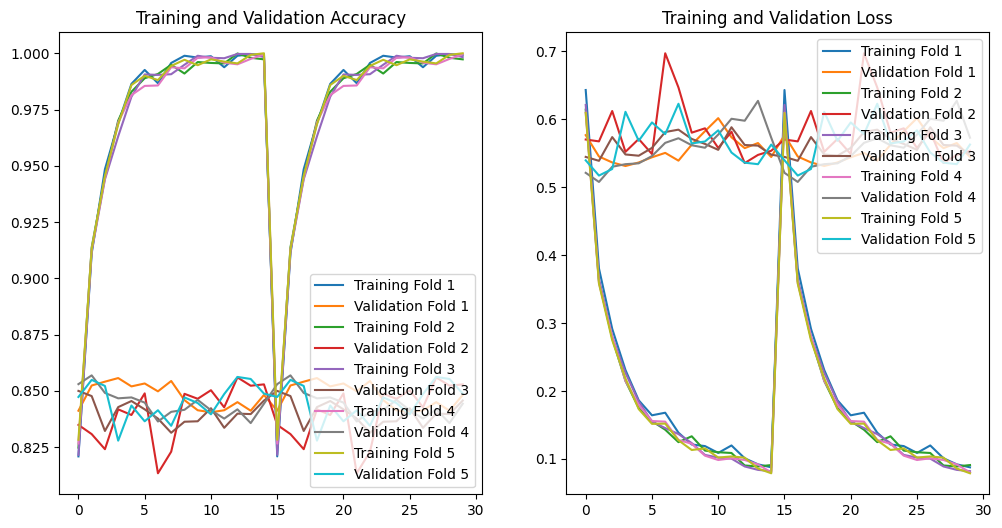

In [ ]:
import matplotlib.pyplot as plt

# 시각화 함수 정의 (Fine-Tuning 후 앙상블 성능 반영)
def plot_history(history_list, history_fine_list=None):
    plt.figure(figsize=(12, 6))

    for fold, history in enumerate(history_list):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        if history_fine_list:
            acc += history_fine_list[fold].history['accuracy']
            val_acc += history_fine_list[fold].history['val_accuracy']
            loss += history_fine_list[fold].history['loss']
            val_loss += history_fine_list[fold].history['val_loss']

        plt.subplot(1, 2, 1)
        plt.plot(acc, label=f'Training Fold {fold+1}')
        plt.plot(val_acc, label=f'Validation Fold {fold+1}')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(loss, label=f'Training Fold {fold+1}')
        plt.plot(val_loss, label=f'Validation Fold {fold+1}')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

    plt.show()

# Fine-Tuning 후 시각화 실행
plot_history(history_fine_list, history_fine_list)